<a href="https://colab.research.google.com/github/WinTranIT/ProjectML/blob/main/Predict_Student_Achievement_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Đây là project dự đoán thành tích của học sinh dựa theo giới tính, dân tộc, cấp học, điểm số các bài kiểm tra.**
Nhóm sinh viên thực hiện:

*   Nguyễn Hoàng Lập - 21130419
*   Trần Bùi Quốc Thắng - 21130536



### 1. Import các thư viện cần thiết

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error

### 2. Load data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/Colab Notebooks'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Colab Notebooks


In [ ]:
data = pd.read_csv('exams.csv')
data.head(5)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group D,some college,standard,completed,59,70,78
1,male,group D,associate's degree,standard,none,96,93,87
2,female,group D,some college,free/reduced,none,57,76,77
3,male,group B,some college,free/reduced,none,70,70,63
4,female,group D,associate's degree,standard,none,83,85,86


In [ ]:
data.shape

(1000, 8)

### 3. Preprocessing Data

3.1 kiểm tra dữ liệu khiếm khuyết


In [ ]:
#kiểm tra dữ liệu khiếm khuyết
data.isnull().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

từ kết quả 3.1 thì thấy dataset không có dữ liệu khiếm khuyết, tiến hành các bước kiểm tra tiếp

3.2 Kiểm tra trùng lặp dữ liệu

In [ ]:
data.duplicated().sum()

0

kết quả 3.2, dataset không có dữ liệu bị trùng lặp

3.3 Kiểm tra kiểu dữ liệu

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [ ]:
data.dtypes

gender                         object
race/ethnicity                 object
parental level of education    object
lunch                          object
test preparation course        object
math score                      int64
reading score                   int64
writing score                   int64
dtype: object

3.4 Kiểm tra số lượng giá trị duy nhất của mỗi cột

In [ ]:
data.nunique()

gender                          2
race/ethnicity                  5
parental level of education     6
lunch                           2
test preparation course         2
math score                     79
reading score                  71
writing score                  74
dtype: int64

3.5 Kiểm tra thống kê của tập dữ liệu

In [ ]:
data.describe()

,math score,reading score,writing score
count,1000.000000,1000.000000,1000.000000
mean,67.810000,70.382000,69.140000
std,15.250196,14.107413,15.025917
min,15.000000,25.000000,15.000000
25%,58.000000,61.000000,59.000000
50%,68.000000,70.500000,70.000000
75%,79.250000,80.000000,80.000000
max,100.000000,100.000000,100.000000



*   Từ mô tả trên về dữ liệu số, tất cả các giá trị trung bình (means) đều rất gần nhau trong khoảng từ 67 đến 69.
*   Tất cả các độ lệch chuẩn (std) rất gần - trong khoảng từ 14.1 đến 15.25.
*   Trong khi có một giá trị tối thiểu (min) là 15 cho môn toán, các môn khác có giá trị là 25 và 15.





"



3.6 	Kiểm tra các danh mục khác nhau có trong các cột phân loại khác nhau

In [ ]:
#phân tách các đặc trưng số và phân loại
numerical_features = [features for features in data.columns if data[features].dtype!='O']
categorical_features = [features for features in data.columns if data[features].dtype == 'O']

In [ ]:
#các đặc trưng có dạng số
numerical_features

['math score', 'reading score', 'writing score']

In [ ]:
categorical_features

['gender',
 'race/ethnicity',
 'parental level of education',
 'lunch',
 'test preparation course']

In [ ]:
#số lượng mẫu theo giới tính (gender)
data['gender'].value_counts()

gender
male      508
female    492
Name: count, dtype: int64

In [ ]:
#số lượng mẫu theo dân tộc
data['race/ethnicity'].value_counts()

race/ethnicity
group C    323
group D    257
group B    198
group E    143
group A     79
Name: count, dtype: int64

In [ ]:
#Tổng hợp tổng điểm bằng giá trị trung bình
data1=data
data1['total_score'] = (data['math score']+data['reading score']+data['writing score'])

In [ ]:

data1['average'] = data1['total_score']/3


In [ ]:
data1['total_score'].max()
#điểm cao nhất đạt được bởi học sinh có id 300

300

In [ ]:
data['total_score'].min()
#điểm thấp nhất đạt được bởi học sinh là 27

60

<Axes: xlabel='average', ylabel='Count'>

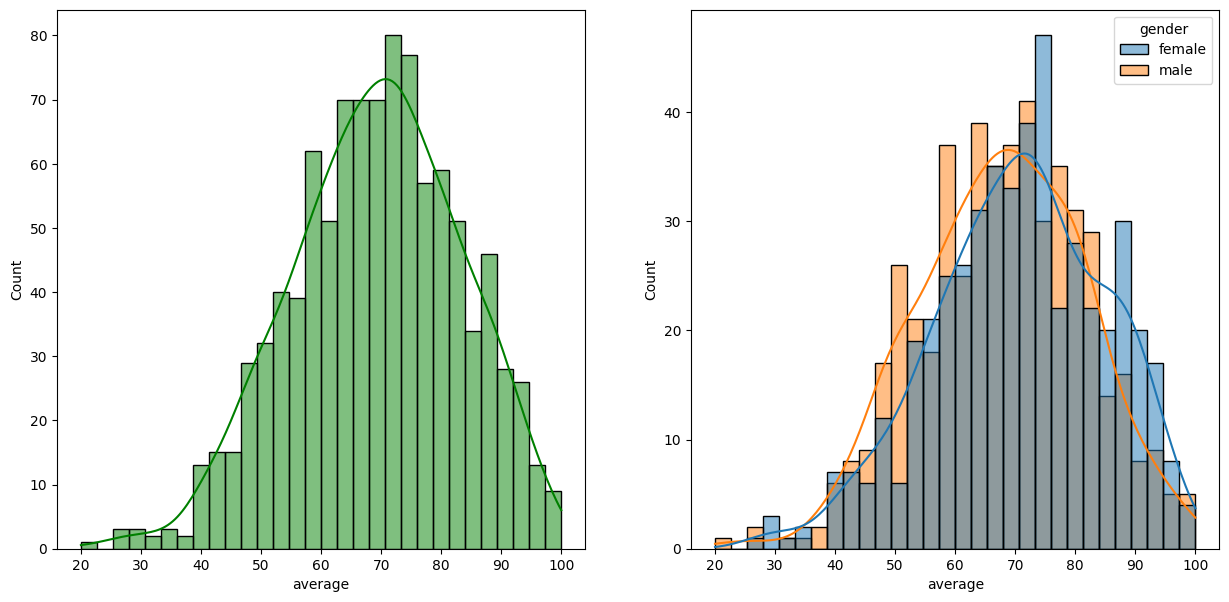

In [ ]:
fig,axis=plt.subplots(1,2,figsize=(15,7))
plt.subplot(121)
sns.histplot(data = data1,x = 'average' , bins = 30 ,kde = True,color='g')
plt.subplot(122)
sns.histplot(data=data1,x='average',bins=30,kde=True,hue='gender')

từ đồ thị, xu hướng là học sinh nữ (female) có hiệu xuất học tập (performance) tốt hơn học sinh nam (male)

<ipython-input-441-db93050c312c>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(141)
<ipython-input-441-db93050c312c>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(142)
<ipython-input-441-db93050c312c>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(143)


<Axes: xlabel='average', ylabel='Count'>

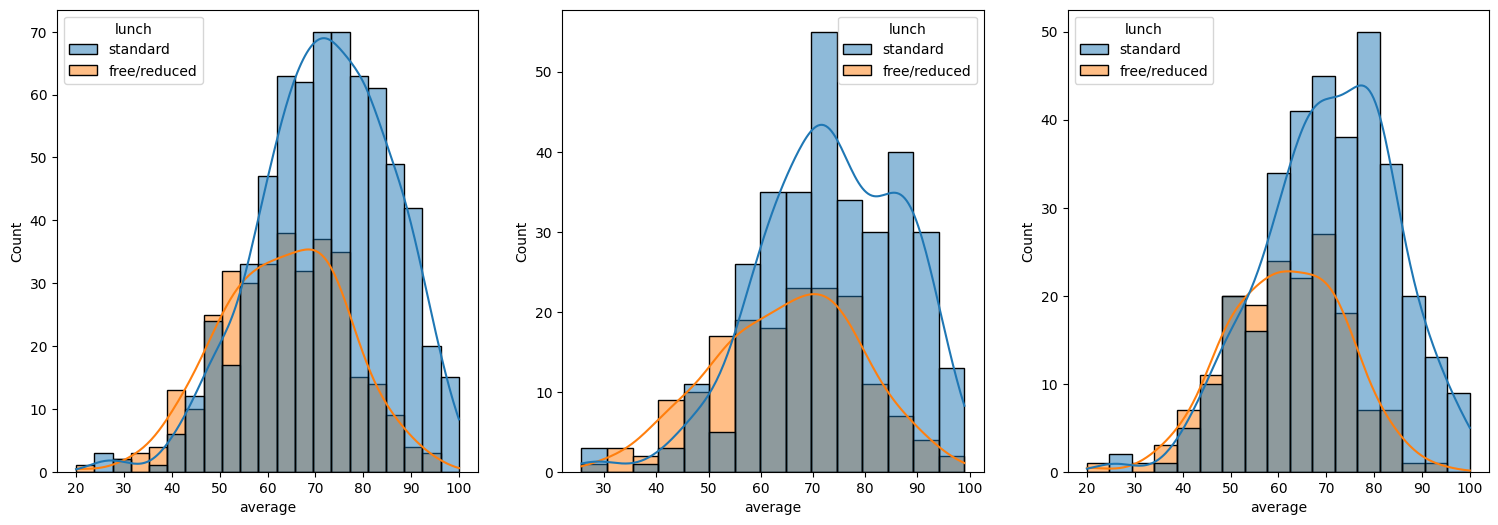

In [ ]:
plt.subplots(1,3,figsize=(25,6))
plt.subplot(141)
sns.histplot(data=data1,x='average',kde=True,hue='lunch')
plt.subplot(142)
sns.histplot(data=data1[data1.gender=='female'],x='average',kde=True,hue='lunch')
plt.subplot(143)
sns.histplot(data=data1[data1.gender=='male'],x='average',kde=True,hue='lunch')

Từ đồ thị:
*   Bữa trưa đạt mức tiêu chuẩn (standard) thì giúp học sinh dạt hiệu xuất cao hơn trong bài thi
*  Hiệu xuất của bữa trưa tiêu chuẩn tác động dến cả nam và nữ không phân biệt giới tính

<ipython-input-442-5a4b723ee58b>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(141)
<ipython-input-442-5a4b723ee58b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(142)
<ipython-input-442-5a4b723ee58b>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(143)


<Axes: xlabel='average', ylabel='Count'>

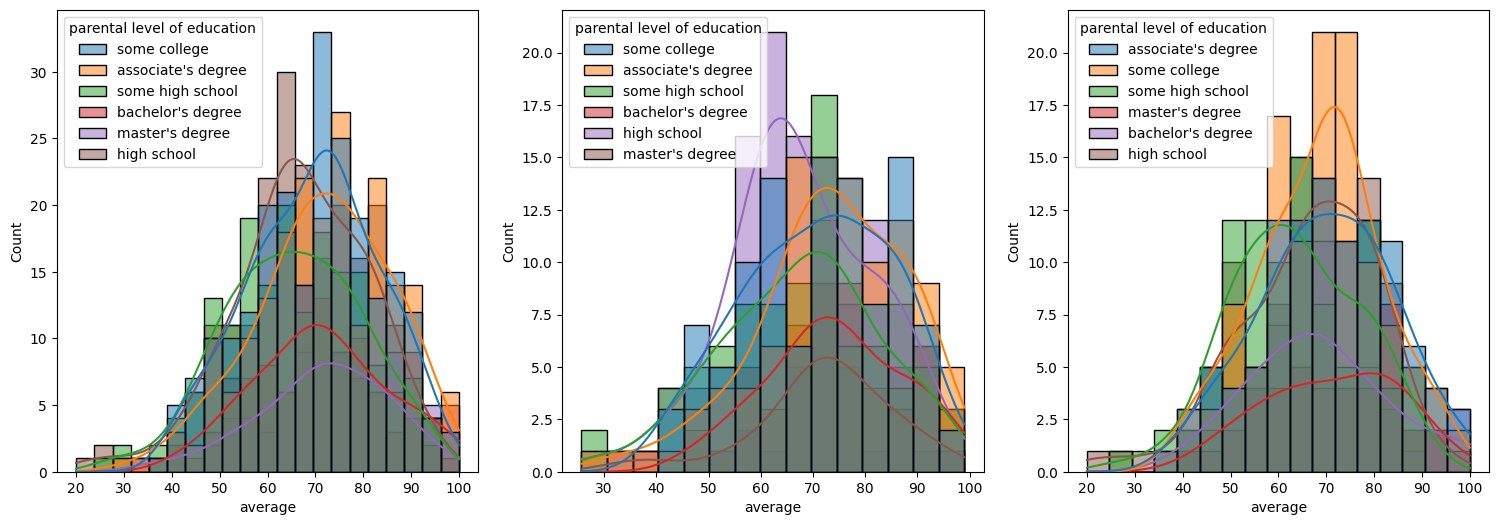

In [ ]:
plt.subplots(1,3,figsize=(25,6))
plt.subplot(141)
sns.histplot(data=data1,x='average',kde=True,hue='parental level of education')
plt.subplot(142)
sns.histplot(data=data1[data1.gender=='female'],x='average',kde=True,hue='parental level of education')
plt.subplot(143)
sns.histplot(data=data1[data1.gender=='male'],x='average',kde=True,hue='parental level of education')

Từ đồ thị:
*   Nhìn chung, trình độ học vấn của cha mẹ không giúp học sinh thi tốt.
*   Biểu đồ thứ 3 cho thấy con trai của những cha mẹ có trình độ học vấn là bằng cao đẳng hoặc bằng thạc sĩ có xu hướng thi tốt

từ các phân tích trên thì có **khả năng cao nhất** cho việc 1 học sinh có hiệu xuất học tập tốt đó là:
*   Học sinh đó là nữ
*   Học sinh đó có ba/mẹ có bằng master degree
*   học sinh đó có bữa trưa tiêu chuẩn

3.5 đổi tên các cột







In [ ]:
data.rename(columns={
    'race/ethnicity': 'Race',
    'parental level of education': 'ParentsEducation',
    'test preparation course': 'TestPrepCourse',
    'math score': 'MathScore',
    'reading score': 'ReadingScore',
    'writing score': 'WritingScore',
    'gender':'Gender'
}, inplace=True)
data.head(5)

,Gender,Race,ParentsEducation,lunch,TestPrepCourse,MathScore,ReadingScore,WritingScore,total_score,average
0,female,group D,some college,standard,completed,59,70,78,207,69.000000
1,male,group D,associate's degree,standard,none,96,93,87,276,92.000000
2,female,group D,some college,free/reduced,none,57,76,77,210,70.000000
3,male,group B,some college,free/reduced,none,70,70,63,203,67.666667
4,female,group D,associate's degree,standard,none,83,85,86,254,84.666667


3.6 Mã hóa one-hot các biến định tính

In [ ]:
# Tạo các nhóm điểm
data['AverageScore'] = data[['MathScore', 'ReadingScore', 'WritingScore']].mean(axis=1)

bins = [0, 60, 70, 80, 100]
labels = ['bad', 'average', 'good', 'excellent']

# Tạo cột ScoreCategory
data['ScoreCategory'] = pd.cut(data['AverageScore'], bins=bins, labels=labels, include_lowest=True)

In [ ]:
data.head(5)

,Gender,Race,ParentsEducation,lunch,TestPrepCourse,MathScore,ReadingScore,WritingScore,total_score,average,AverageScore,ScoreCategory
0,female,group D,some college,standard,completed,59,70,78,207,69.000000,69.000000,average
1,male,group D,associate's degree,standard,none,96,93,87,276,92.000000,92.000000,excellent
2,female,group D,some college,free/reduced,none,57,76,77,210,70.000000,70.000000,average
3,male,group B,some college,free/reduced,none,70,70,63,203,67.666667,67.666667,average
4,female,group D,associate's degree,standard,none,83,85,86,254,84.666667,84.666667,excellent


In [ ]:
data.drop(columns=['AverageScore','total_score',	'average'], inplace=True)


In [ ]:
data.head(5)

,Gender,Race,ParentsEducation,lunch,TestPrepCourse,MathScore,ReadingScore,WritingScore,ScoreCategory
0,female,group D,some college,standard,completed,59,70,78,average
1,male,group D,associate's degree,standard,none,96,93,87,excellent
2,female,group D,some college,free/reduced,none,57,76,77,average
3,male,group B,some college,free/reduced,none,70,70,63,average
4,female,group D,associate's degree,standard,none,83,85,86,excellent


In [ ]:
scaler = StandardScaler()
data[['MathScore', 'ReadingScore', 'WritingScore']] = scaler.fit_transform(data[['MathScore', 'ReadingScore', 'WritingScore']])

In [ ]:
data.head(6)

,Gender,Race,ParentsEducation,lunch,TestPrepCourse,MathScore,ReadingScore,WritingScore,total_score,average,ScoreCategory
0,0,3,4,1,0,-0.577987,-0.027092,0.589943,207,69.000000,to improve
1,1,3,0,1,1,1.849426,1.604073,1.189208,276,92.000000,succesful
2,0,3,4,0,1,-0.709198,0.398430,0.523358,210,70.000000,to improve
3,1,1,4,0,1,0.143677,-0.027092,-0.408832,203,67.666667,to improve
4,0,3,0,1,1,0.996551,1.036711,1.122623,254,84.666667,succesful
5,1,2,5,1,1,0.012465,-0.949054,-1.008097,179,59.666667,unsuccessful


In [ ]:
data_encoded = pd.get_dummies(data, columns=['Gender', 'Race', 'ParentsEducation', 'lunch', 'TestPrepCourse'])


In [ ]:
data_encoded.head(5)

,MathScore,ReadingScore,WritingScore,ScoreCategory,Gender_0,Gender_1,Race_0,Race_1,Race_2,Race_3,...,ParentsEducation_0,ParentsEducation_1,ParentsEducation_2,ParentsEducation_3,ParentsEducation_4,ParentsEducation_5,lunch_0,lunch_1,TestPrepCourse_0,TestPrepCourse_1
0,59,70,78,average,True,False,False,False,False,True,...,False,False,False,False,True,False,False,True,True,False
1,96,93,87,exelent,False,True,False,False,False,True,...,True,False,False,False,False,False,False,True,False,True
2,57,76,77,average,True,False,False,False,False,True,...,False,False,False,False,True,False,True,False,False,True
3,70,70,63,average,False,True,False,True,False,False,...,False,False,False,False,True,False,True,False,False,True
4,83,85,86,good,True,False,False,False,False,True,...,True,False,False,False,False,False,False,True,False,True


In [ ]:
# cols = ['gender', 'Race', 'ParentsEducation', 'lunch', 'TestPrepCourse']
# data = pd.get_dummies(data, columns=cols)
# data.head(5)

,MathScore,ReadingScore,WritingScore,gender_female,gender_male,Race_group A,Race_group B,Race_group C,Race_group D,Race_group E,ParentsEducation_associate's degree,ParentsEducation_bachelor's degree,ParentsEducation_high school,ParentsEducation_master's degree,ParentsEducation_some college,ParentsEducation_some high school,lunch_free/reduced,lunch_standard,TestPrepCourse_completed,TestPrepCourse_none
0,59,70,78,True,False,False,False,False,True,False,False,False,False,False,True,False,False,True,True,False
1,96,93,87,False,True,False,False,False,True,False,True,False,False,False,False,False,False,True,False,True
2,57,76,77,True,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,True
3,70,70,63,False,True,False,True,False,False,False,False,False,False,False,True,False,True,False,False,True
4,83,85,86,True,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,True


3.7 Chọn đặc trưng (X) và cột đích (y)

In [ ]:
X = data_encoded.drop(columns= ['MathScore','ReadingScore','WritingScore', 'ScoreCategory'])
y = data_encoded['ScoreCategory']

In [ ]:
X.head(5)

,Gender_0,Gender_1,Race_0,Race_1,Race_2,Race_3,Race_4,ParentsEducation_0,ParentsEducation_1,ParentsEducation_2,ParentsEducation_3,ParentsEducation_4,ParentsEducation_5,lunch_0,lunch_1,TestPrepCourse_0,TestPrepCourse_1
0,True,False,False,False,False,True,False,False,False,False,False,True,False,False,True,True,False
1,False,True,False,False,False,True,False,True,False,False,False,False,False,False,True,False,True
2,True,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,True
3,False,True,False,True,False,False,False,False,False,False,False,True,False,True,False,False,True
4,True,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,True


In [ ]:
y.head(5)

0    average
1    exelent
2    average
3    average
4       good
Name: ScoreCategory, dtype: category
Categories (4, object): ['bad' < 'average' < 'good' < 'exelent']

3.8 Chuẩn hóa các đặc trưng

In [ ]:
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

### 4. Chia tập dữ liệu thành 80% train và 20% test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.head(5)

,Gender_0,Gender_1,Race_0,Race_1,Race_2,Race_3,Race_4,ParentsEducation_0,ParentsEducation_1,ParentsEducation_2,ParentsEducation_3,ParentsEducation_4,ParentsEducation_5,lunch_0,lunch_1,TestPrepCourse_0,TestPrepCourse_1
29,False,True,False,False,False,True,False,True,False,False,False,False,False,False,True,False,True
535,False,True,False,True,False,False,False,False,False,False,False,False,True,True,False,True,False
695,True,False,False,False,False,True,False,False,False,False,False,False,True,False,True,True,False
557,True,False,False,False,False,False,True,True,False,False,False,False,False,True,False,False,True
836,True,False,True,False,False,False,False,False,False,False,True,False,False,False,True,True,False


In [ ]:
print(y_train)

29        good
535        bad
695       good
557    average
836    average
        ...   
106    average
270       good
860       good
435       good
102    average
Name: ScoreCategory, Length: 800, dtype: category
Categories (4, object): ['bad' < 'average' < 'good' < 'exelent']


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
print(X_train_scaled)

[[-0.99252792  0.99252792 -0.29738086 ...  0.74593581 -0.70578137
   0.70578137]
 [-0.99252792  0.99252792 -0.29738086 ... -1.34059793  1.41686936
  -1.41686936]
 [ 1.00752834 -1.00752834 -0.29738086 ...  0.74593581  1.41686936
  -1.41686936]
 ...
 [-0.99252792  0.99252792 -0.29738086 ...  0.74593581  1.41686936
  -1.41686936]
 [ 1.00752834 -1.00752834 -0.29738086 ...  0.74593581  1.41686936
  -1.41686936]
 [-0.99252792  0.99252792 -0.29738086 ...  0.74593581 -0.70578137
   0.70578137]]


### 5. Với KNeighbors Classifier

In [ ]:
k = []
Accuracy = []
Precission = []
Recall = []
F1 = []
for i in range(3, 39, 2):
  k.append(i)
  model_knn = KNeighborsClassifier(n_neighbors=i)
  model_knn.fit(X_train_scaled,y_train)
  y_pred_knn = model_knn.predict(X_test_scaled)
  Accuracy.append(accuracy_score(y_test, y_pred_knn))
  Precission.append(precision_score(y_test, y_pred_knn, average='weighted'))
  Recall.append(recall_score(y_test, y_pred_knn, average='weighted'))
  F1.append(f1_score(y_test, y_pred_knn, average='weighted'))



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

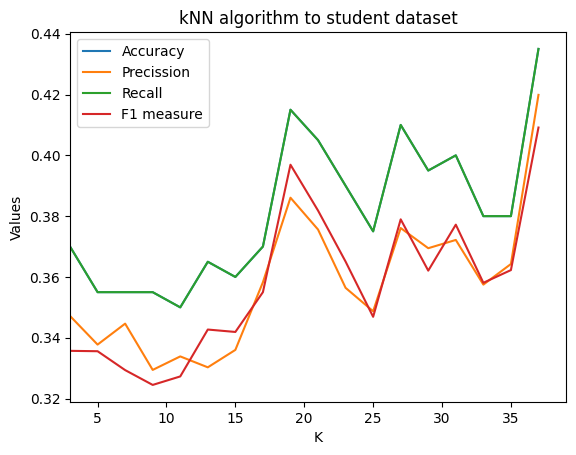

In [ ]:
plt.plot(k,Accuracy, label="Accuracy")
plt.plot(k,Precission,label='Precission')
plt.plot(k,Recall,label='Recall')
plt.plot(k,F1,label="F1 measure")
plt.xlabel('K')
plt.ylabel('Values')
plt.xlim(3,39)
plt.title('kNN algorithm to student dataset')
plt.legend()
plt.show()

5. Với Naïve Bayes

In [ ]:
# Khởi tạo mô hình Naïve Bayes

nb_model = GaussianNB()

# Huấn luyện mô hình
nb_model.fit(X_train_scaled, y_train)

# Dự đoán trên tập kiểm tra
y_pred_nb = nb_model.predict(X_test_scaled)

# Đánh giá mô hình Naïve Bayes
accuracy_nb = accuracy_score(y_test, y_pred_nb)
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)
class_report_nb = classification_report(y_test, y_pred_nb)

In [ ]:
print(f"Accuracy: {accuracy_nb}")
print("Confusion Matrix:")
print(conf_matrix_nb)
print("Classification Report:")
print(class_report_nb)

Accuracy: 0.27
Confusion Matrix:
[[21 19 38  7]
 [ 7 15 17  1]
 [ 1  0 12  0]
 [ 6  5 45  6]]
Classification Report:
              precision    recall  f1-score   support

     average       0.60      0.25      0.35        85
         bad       0.38      0.38      0.38        40
     exelent       0.11      0.92      0.19        13
        good       0.43      0.10      0.16        62

    accuracy                           0.27       200
   macro avg       0.38      0.41      0.27       200
weighted avg       0.47      0.27      0.29       200



In [ ]:
from sklearn.linear_model import LogisticRegression

model_ls = LogisticRegression(max_iter=1000)
model_ls.fit(X_train_scaled, y_train)
y_pred_ls = model_ls.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred_ls)
report = classification_report(y_test, y_pred_ls)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.435
Classification Report:
              precision    recall  f1-score   support

     average       0.43      0.62      0.51        85
         bad       0.35      0.33      0.34        40
     exelent       0.17      0.08      0.11        13
        good       0.57      0.32      0.41        62

    accuracy                           0.43       200
   macro avg       0.38      0.34      0.34       200
weighted avg       0.44      0.43      0.42       200



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


model_rd = RandomForestClassifier(n_estimators=100, random_state=42)
model_rd.fit(X_train_scaled, y_train)
y_pred_rd = model_rd.predict(X_test_scaled)
accuracy_rd = accuracy_score(y_test, y_pred_rd)
conf_matrix_rd = confusion_matrix(y_test, y_pred_rd)
class_report_rd = classification_report(y_test, y_pred_rd)

In [ ]:
print(f"Accuracy: {accuracy_rd}")
print("Confusion Matrix:")
print(conf_matrix_rd)
print("Classification Report:")
print(class_report_rd)

Accuracy: 0.345
Confusion Matrix:
[[40 23  8 14]
 [25 10  0  5]
 [ 7  1  0  5]
 [31  6  6 19]]
Classification Report:
              precision    recall  f1-score   support

     average       0.39      0.47      0.43        85
         bad       0.25      0.25      0.25        40
     exelent       0.00      0.00      0.00        13
        good       0.44      0.31      0.36        62

    accuracy                           0.34       200
   macro avg       0.27      0.26      0.26       200
weighted avg       0.35      0.34      0.34       200



6.Đánh giá mô hình